<a href="https://colab.research.google.com/github/whoawoo/api_class/blob/main/tf_flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.데이터셋 내려받기

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tfds.__version__

'4.9.2'

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers', # 3.670 items
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [ ]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = image/255 # 픽셀값의 scale 수정 # 기존 0~255 정수값을 0~1사이 실수값으로 변경
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("완료")

완료


In [ ]:
train= raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


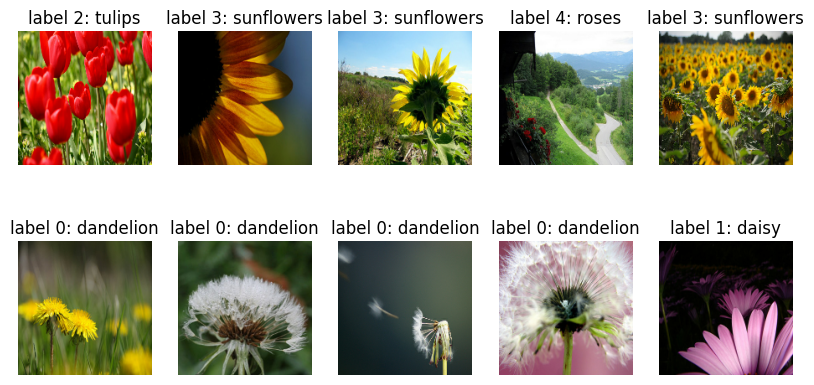

In [ ]:
#check
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

3. 모델 설계하기

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

# model sequential

base_model = tf.keras.Sequential([
    model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

base_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


4. 모델 학습시키기

In [ ]:
learning_rate = 0.001
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("완료")

완료


In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("완료")

완료


In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("완료")

완료


In [ ]:
# 초기 손실과 정확도 검사
validation_steps= 10
loss0, accuracy0 = base_model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

10/10 [==============================] - 105s 10s/step - loss: 1.6887 - accuracy: 0.1406
initial loss: 1.69
initial accuracy: 0.14


In [ ]:
EPOCHS = 10
history = base_model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
92/92 [==============================] - 1030s 11s/step - loss: 1.0321 - accuracy: 0.6124 - val_loss: 0.7699 - val_accuracy: 0.7003
Epoch 2/10
92/92 [==============================] - 1059s 12s/step - loss: 0.7140 - accuracy: 0.7371 - val_loss: 0.6694 - val_accuracy: 0.7466
Epoch 3/10
92/92 [==============================] - 1011s 11s/step - loss: 0.6287 - accuracy: 0.7721 - val_loss: 0.6921 - val_accuracy: 0.7357
Epoch 4/10
92/92 [==============================] - 1009s 11s/step - loss: 0.5682 - accuracy: 0.8021 - val_loss: 0.5850 - val_accuracy: 0.7711
Epoch 5/10
92/92 [==============================] - 1011s 11s/step - loss: 0.5273 - accuracy: 0.8178 - val_loss: 0.6816 - val_accuracy: 0.7629
Epoch 6/10
20/92 [=====>........................] - ETA: 11:20 - loss: 0.4632 - accuracy: 0.8469

5. 모델 성능 평가하기

In [ ]:
# 그래프로 학습과정을 보자

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
import numpy as np
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = base_model.predict(image_batch)
    pass

predictions = np.argmax(predictions, axis=1)
predictions
array([2, 0, 3, 2, 0, 0, 4, 1, 3, 0, 0, 3, 4, 2, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])